# Import all Libraries

In [1]:
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

# Connect to Elastic Search

In [2]:
# create a client instance of the library
es = Elasticsearch(host='localhost', port=9200)

# Function to fetch the Ids and their Respective Messages

In [3]:
def get_data_from_elastic():
    # query: The elasticsearch query.
    query = {
    
    }
    # Scan function to get all the data. 
    response = scan(client=es,             
               query=query,                                     
               scroll='2m',
               index='*.27',
               raise_on_error=True,
               preserve_order=False,
               clear_scroll=True)

    # Keep response in a list.
    result = list(response)
    print("! ",result)
    ids =[]
    for i in range(len(result)):
        ids.append(result[i]["_id"])
    temp = []
    
    # We need only '_source', which has all the fields required.
    for hit in result:
        
        temp.append(hit['_source'])
    # Create a dataframe.
    df = pd.DataFrame(temp)

    return (ids,df)

In [4]:
lol = get_data_from_elastic()
ids = lol[0]
df = lol[1]

C:\Users\akesar\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
# print(*ids)

In [ ]:
#First 1000 data from the DataFrame
df.head(1000)

In [ ]:
#Meassage Example
df['message'][1]

In [7]:
#Get the message list from the dataFrame for Text Cleaning, Tokenization,etc.
msg_list = list(df['message'])
# for i in range(len(msg_list)):
#     print(msg_list[i])

In [8]:
for msg in msg_list:
    #To replace \220 with another value
    msg.replace('\220','>')

# Text Cleaning

In [9]:
import re
import html

clean_msg_list=[]
for msg in msg_list:
    #various regular expressions to clean the message data
    #To clear the hyperlinks
    msg = re.sub(r'https?:\/\/.\S+', "", msg)
    #To clean the date and time from the msgs
    msg = re.sub(r'(\S\S \S\S\S )?\S\S\S( )? (\d)?\d \d\d:\d\d:\d\d (\d\d\d\d)?','',msg)
    #To remove various emailIds
    msg = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$','',msg)
    #To remove ... special characters from the msgs
    msg = re.sub('\...+','',msg)
    #To remove � from the msgs
    msg = re.sub(r'\S\�+','',msg)
    #To remove any substring of #%abc42 type
    msg = re.sub('\%\w+','',msg)
    #To remove the word combo from the msgs
    msg = re.sub('combo',"",msg)
    #To remove Blank Lines
    msg = re.sub(r'\n\s*\r ','',msg)
    #To remove punctuation
    msg = re.sub(r'[^\w\s]','',msg)
    #To remove digits from the messages
    msg = re.sub(r'\d+','',msg)
    #To remove any html links
    msg= html.unescape(msg)
    clean_msg_list.append(msg)

# Tokenization

In [10]:
#Word tokenization
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize


stop_words = list(set(stopwords.words('english')))
stop_words = stop_words+['logname', 'uid','eth','euid','PCI','node','Privacy','IRQ','ttyNODEVssh', 'ruser','rhostjwhp5','IPv','tables','Microcode', 'Driver','Hash', 'interface','family','httpd','info', 'mice','check','pass','cache','spamd','bytes','syslog','klogd','BIOS','protocol','NET','md','arrays','filesystem','CPU','user', 'cyrus','dev', 'type', 'ext3', 'uses','others','internal', 'service','already','floppy','syslogd','ip_tables','startup','use','NET', 'Registered', 'Revision','CDROM', 'drive','hda']
new_Doc=[]
for msg in clean_msg_list:
    nltk_tokens = nltk.word_tokenize(msg)
    filtered_sentence = []
    for w in nltk_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    new_Doc.append(filtered_sentence)
# print(new_Doc)        

# More research on domain stop words.

# Lemmatization

In [11]:
from nltk.stem.wordnet import WordNetLemmatizer as wl
wordnet = wl()

doc =[]
for docs in new_Doc:
    arr =[]
    for word in docs:
        arr.append(wordnet.lemmatize(word))
    doc.append(arr)


# Re-Formation/DeTokenization

In [12]:
from sacremoses import MosesDetokenizer

parsed_logs=[]
for words in doc:
    detokens = MosesDetokenizer().detokenize(words, return_str=True)
    parsed_logs.append(detokens)

In [12]:
# parsed_logs

In [ ]:
print(type(df['agent'][1]))

In [ ]:
textfile = open(r"C:/Users/akesar01/Documents/Logs/ParsedLogs.txt", "r+")
textfile.write('id'+","+'message'+","+'@version'+","+'@timestamp'+"\n")
for i in range(len(parsed_logs)):
    textfile.write(ids[i]+","+parsed_logs[i]+","+df['@version'][i]+","+df['@timestamp'][i]+"\n")
textfile.close()

In [ ]:
es.info()

In [ ]:
resp = es.get(index="filebeat-7.16.3-2022.03.10", id=ids[0])
print(resp['_source'])

In [ ]:
parsed_logs[0]

In [ ]:
resp = es.get(index="gamma_2", id= 'Vy7ajH8BLOYn9AgzScoh')
print(resp['_source'])

# TFIDF Differentiation


### The purpose of TF - IDF is to highlight words which are frequent  in a document but not cross document

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = parsed_logs

In [14]:
vectorizer = TfidfVectorizer()

In [15]:
result = vectorizer.fit_transform(text)

In [17]:
# print(vectorizer.idf_)

In [ ]:
print(vectorizer.vocabulary_)

In [16]:
lol = [(k, vectorizer.vocabulary_[k]) for k in vectorizer.vocabulary_]

In [20]:
# sorted(lol,key = lambda x: x[1])

In [17]:
arr = result.toarray()


In [18]:
idf_df = pd.DataFrame(result.toarray(),columns=vectorizer.get_feature_names())

C:\Users\akesar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
idf_df

,__alloc_pagesxx,__call_console_driversxx,__fputxbxd,__getblk_slowxaxcb,__getblkxxb,__mark_inode_dirtyxxca,__print_symbolxx,__wake_up_commonxfx,__wake_upxex,aa,...,xffaxffaf,xfs,xfxfxf,xinetd,xx,xxx,you,zapping,zone,zonelists
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## KMeans Clustering

In [35]:
from sklearn.cluster import KMeans
number_of_clusters=2
km = KMeans(n_clusters=number_of_clusters)

In [37]:
km.fit(result)

KMeans(n_clusters=2)

In [38]:
km.fit

<bound method KMeans.fit of KMeans(n_clusters=2)>

In [39]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ftpd connection sshdpam_unix failure authentication rhost unknown kernel session supam_unix
Cluster 1: killed out memory process kernel python sendmail mrtg mysqld updatedb


C:\Users\akesar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
results = pd.DataFrame()
results['text'] = text
results['category'] = km.labels_
results

,text,category
0,rpc,0
1,sshdpam_unix authentication failure rhost,0
2,sshdpam_unix authentication failure rhost,0
3,sshdpam_unix unknown,0
4,sshdpam_unix authentication failure rhost,0
...,...,...
25562,messagebus messagebus succeeded,0
25563,succeeded,0
25564,squid Squid Parent child process started,0
25565,named starting BIND,0


## 3 categories

In [30]:
from sklearn.cluster import KMeans

number_of_clusters=3
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(result)
km.fit

<bound method KMeans.fit of KMeans(n_clusters=3)>

In [31]:
results = pd.DataFrame({
    'text': text,
    'category': km.labels_
})
results

,text,category
0,rpc,0
1,sshdpam_unix authentication failure rhost,0
2,sshdpam_unix authentication failure rhost,0
3,sshdpam_unix unknown,0
4,sshdpam_unix authentication failure rhost,0
...,...,...
25562,messagebus messagebus succeeded,0
25563,succeeded,0
25564,squid Squid Parent child process started,0
25565,named starting BIND,0


In [33]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: sshdpam_unix failure authentication rhost unknown kernel session supam_unix opened closed
Cluster 1: killed out memory process kernel python sendmail mrtg mysqld updatedb
Cluster 2: ftpd connection zonelists getpeername hci hash hardware hard handle_mm_faultxxe handle_mm_faultxdxe


## WCSS method

In [48]:
wcss_list= [] 
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i)  
    kmeans.fit(result)  
    wcss_list.append(kmeans.inertia_)


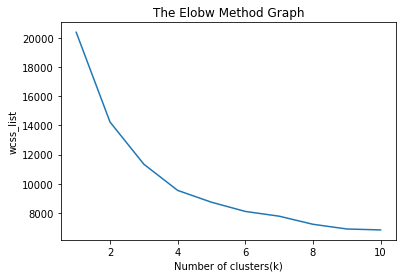

In [49]:
import matplotlib.pyplot as mtp
mtp.plot(range(1, 11), wcss_list)  
mtp.title('The Elobw Method Graph')  
mtp.xlabel('Number of clusters(k)')  
mtp.ylabel('wcss_list')  
mtp.show()  

In [46]:
from sklearn.cluster import KMeans

number_of_clusters=3
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(result)

KMeans(n_clusters=3)

In [47]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: sshdpam_unix failure authentication rhost unknown kernel session supam_unix opened closed
Cluster 1: killed out memory process kernel python sendmail mrtg mysqld updatedb
Cluster 2: ftpd connection zonelists getpeername hci hash hardware hard handle_mm_faultxxe handle_mm_faultxdxe


C:\Users\akesar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
type(order_centroids)

numpy.ndarray

In [52]:
order_centroids

array([[726, 239,  47, ..., 434, 812, 517],
       [371, 470, 418, ..., 561, 560,   0],
       [268, 133, 851, ..., 563, 562,   0]], dtype=int64)

In [56]:
km.cluster_centers_.argsort()[:,::-1]

array([[726, 239,  47, ..., 434, 812, 517],
       [371, 470, 418, ..., 561, 560,   0],
       [268, 133, 851, ..., 563, 562,   0]], dtype=int64)

In [25]:
# print('\nidf values:')
# c=zip(vectorizer.get_feature_names(), vectorizer.idf_)
# for ele1, ele2 in sorted(c,key = lambda x: x[1]):
#     print(ele1, ':', ele2)

# Word2vec

In [30]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score


nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
model = Word2Vec(sentences=doc, vector_size=100, workers=1, seed=SEED)

In [41]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[===============================================---] 94.1% 1565.1/1662.8MB downloaded


In [49]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(2, 100)

In [50]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [50]:
# clustering, cluster_labels = mbkmeans_clusters(
#     X=vectorized_docs,
#     k=50,
#     mb=500,
#     print_silhouette_values=True,
# )
# df_clusters = pd.DataFrame({
#     "text": docs,
#     "tokens": [" ".join(text) for text in tokenized_docs],
#     "cluster": cluster_labels
# })